<a href="https://colab.research.google.com/github/Mifekmk/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_06_Autoencoder_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.06 AutoEncoder

* 날짜: 2022-08-30
* 이름: 김민규

## 학습내용
    - AutoEncoder를 이해하고 구현한다.
    - Denoising 을 적용해 본다. 
    - 이상치 탐지를 적용해 본다. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os

import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## AutoEncoder 기본 구현
---

![](https://gaussian37.github.io/assets/img/dl/concept/autoencoder2/autoencoder.png)

### **| 모델 구성**

In [ ]:
# 이미지 -> 이미지 norm : x/255 x 값이 0~1 사이 (0 또는 1이 아님!)

# mnist : 28 x 28 = 784
def create_model(input_dims=784):
  # encoder
  x = layers.Input(shape=input_dims, name='x')
  z = layers.Dense(128, activation='relu')(x)
  z = layers.Dense(64, activation='relu')(z)
  z = layers.Dense(16, activation='relu')(z)
  encoder = models.Model(x, z, name='Encoder')

  # decoder
  y = layers.Dense(64, activation='relu')(z)
  y = layers.Dense(128, activation='relu')(y)
  y = layers.Dense(input_dims, activation='sigmoid')(y)
  decoder = models.Model(z, y, name='Decoder')

  # AutoEncoder
  z = encoder(x)
  y = decoder(z)
  model = models.Model(x, y, name='AutoEncoder')
  model.compile(loss= 'mse', 
                optimizer='adam')

  model.summary()

  return encoder, decoder, model



In [ ]:
encoder, decoder, model = create_model()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 784)]             0         
                                                                 
 Encoder (Functional)        (None, 16)                109776    
                                                                 
 Decoder (Functional)        (None, 784)               110544    
                                                                 
Total params: 220,320
Trainable params: 220,320
Non-trainable params: 0
_________________________________________________________________


### **| 학습**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# norm
x_train = x_train / 255.0
x_test = x_test / 255.

# flatten
x_train = x_train.reshape( (60000, -1) )
x_test = x_test.reshape( (10000, -1) )

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [ ]:
history = model.fit(x_train, x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 0.0507
Epoch 2/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0258
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0217
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0196
Epoch 5/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0182
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0173
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0166
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0161
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0156
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0153
Epoch 11/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0150
Epoch 12/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0146
Epoch 13/50
469/469

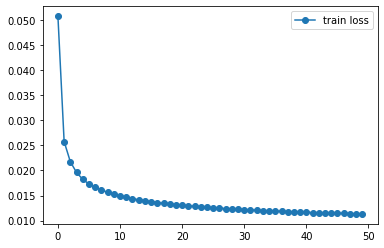

In [ ]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [ ]:
x_recon = model.predict(x_test)
x_test.shape, x_recon.shape

((10000, 784), (10000, 784))

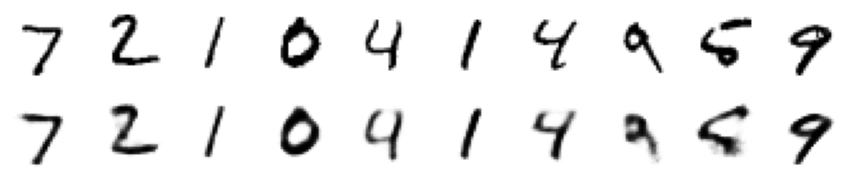

In [ ]:
def display_res(org, rec):
  plt.figure(figsize=(15,3))
  for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(org[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
    plt.subplot(2,10,i+11)
    plt.imshow(rec[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
  plt.show()

display_res(x_test, x_recon)

In [ ]:
z =encoder(x_test[:1000])
z.shape

TensorShape([1000, 16])

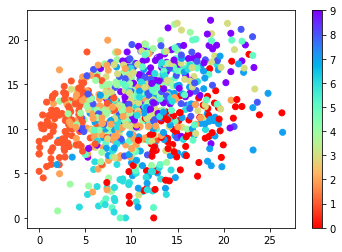

In [ ]:
plt.scatter(z[:,1], z[:,2], c=y_test[:1000], cmap='rainbow_r')
plt.colorbar()

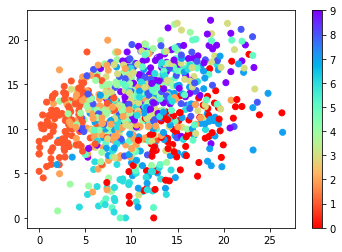

In [ ]:
plt.scatter(z[:,1], z[:,2], c=y_test[:1000], cmap='rainbow_r')
plt.colorbar()
plt.show()

## AutoEncoder 활용 - Denoising
---

### **| 데이터 준비**

(60000, 784) (10000, 784)


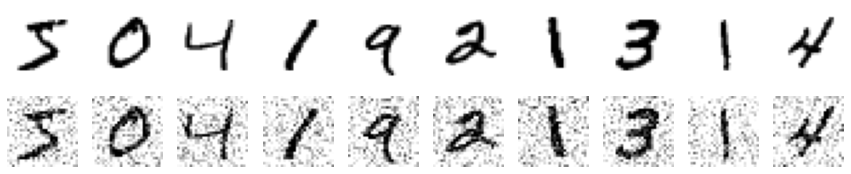

In [ ]:
train_noise = np.random.normal(size=x_train.shape)
test_noise = np.random.normal(size=x_test.shape)

factor=0.25
x_train_noisy = x_train + train_noise * factor
x_test_noisy = x_test + test_noise * factor

# 0~1 범위를 벗어나지 않도록
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(train_noise.shape, test_noise.shape)
display_res(x_train, x_train_noisy)

### **| 훈련**

In [ ]:
histyr = model.fit(x_train_noisy, x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0162
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0143
Epoch 3/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0139
Epoch 4/50
469/469 [==============================] - 5s 12ms/step - loss: 0.0137
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0135
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0134
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0133
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0133
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0132
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0131
Epoch 11/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0131
Epoch 12/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0130
Epoch 13/50
469/469 [=

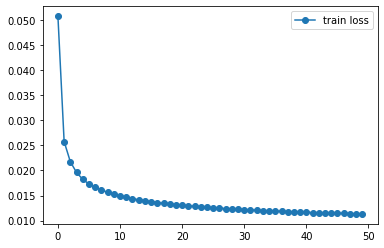

In [ ]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [ ]:
x_recon = model.predict(x_test_noisy)
x_recon.shape, x_test_noisy

((10000, 784),
 array([[0.15185371, 0.        , 0.00111182, ..., 0.19803103, 0.09733888,
         0.05800807],
        [0.        , 0.17163229, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.34131244,
         0.03594265],
        ...,
        [0.06326099, 0.        , 0.        , ..., 0.        , 0.49496506,
         0.        ],
        [0.        , 0.        , 0.08223749, ..., 0.04313885, 0.18479212,
         0.        ],
        [0.        , 0.0314744 , 0.37480638, ..., 0.42048021, 0.17326585,
         0.21135202]]))

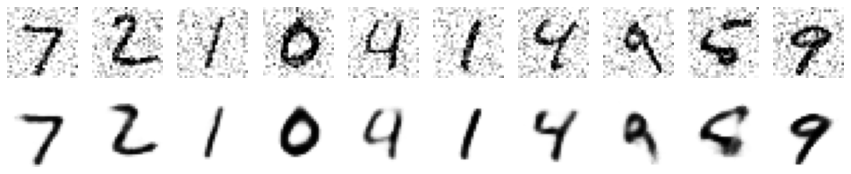

In [ ]:
display_res(x_test_noisy, x_recon)

# Tensorflow & AutoEncoder

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
def preprocess(array):
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape)
    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    # display 10 random images
    
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

(28, 28, 1)


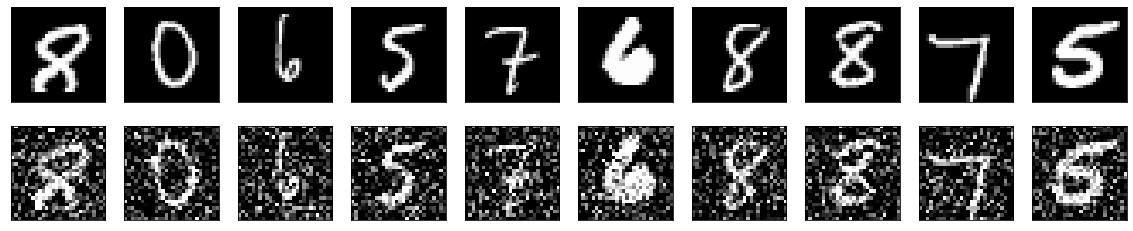

In [ ]:
(train_data, _), (test_data, _) = mnist.load_data()

# normalize
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# add_noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# display
print(train_data[0].shape)
display(train_data, noisy_train_data)

In [ ]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 154s 324ms/step - loss: 0.1356 - val_loss: 0.0736
Epoch 2/50
469/469 [==============================] - 147s 314ms/step - loss: 0.0718 - val_loss: 0.0695
Epoch 3/50
469/469 [==============================] - 149s 318ms/step - loss: 0.0693 - val_loss: 0.0680
Epoch 4/50
469/469 [==============================] - 148s 315ms/step - loss: 0.0681 - val_loss: 0.0672
Epoch 5/50
469/469 [==============================] - 148s 316ms/step - loss: 0.0674 - val_loss: 0.0666
Epoch 6/50
469/469 [==============================] - 148s 316ms/step - loss: 0.0668 - val_loss: 0.0661
Epoch 7/50
469/469 [==============================] - 148s 317ms/step - loss: 0.0664 - val_loss: 0.0657
Epoch 8/50
469/469 [==============================] - 150s 321ms/step - loss: 0.0660 - val_loss: 0.0654
Epoch 9/50
469/469 [==============================] - 148s 315ms/step - loss: 0.0657 - val_loss: 0.0651
Epoch 10/50
469/469 [==============================] - 147s 314m

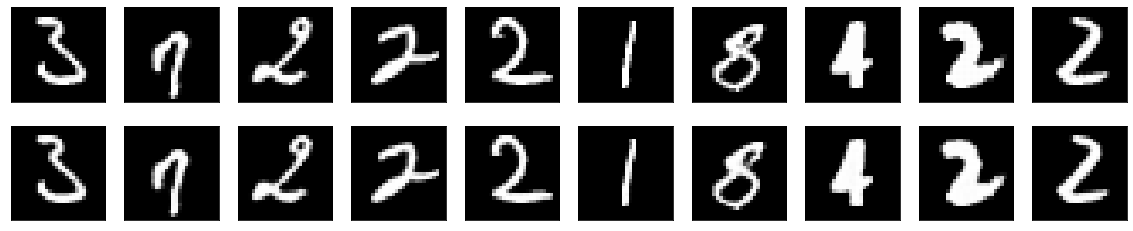

In [ ]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 147s 313ms/step - loss: 0.1002 - val_loss: 0.0933
Epoch 2/100
469/469 [==============================] - 150s 321ms/step - loss: 0.0928 - val_loss: 0.0912
Epoch 3/100
469/469 [==============================] - 150s 321ms/step - loss: 0.0913 - val_loss: 0.0901
Epoch 4/100
469/469 [==============================] - 152s 325ms/step - loss: 0.0903 - val_loss: 0.0895
Epoch 5/100
469/469 [==============================] - 150s 320ms/step - loss: 0.0897 - val_loss: 0.0887
Epoch 6/100
469/469 [==============================] - 150s 320ms/step - loss: 0.0891 - val_loss: 0.0884
Epoch 7/100
469/469 [==============================] - 150s 320ms/step - loss: 0.0887 - val_loss: 0.0881
Epoch 8/100
469/469 [==============================] - 150s 321ms/step - loss: 0.0883 - val_loss: 0.0876
Epoch 9/100
469/469 [==============================] - 150s 320ms/step - loss: 0.0880 - val_loss: 0.0873
Epoch 10/100
469/469 [==============================] -

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

## AutoEncoder 활용 - 이상치 탐지
---

### **| 모델 구성**

In [1]:
import sys, os

import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# conv1d 레이어 사용해서 모델 구성

def create_model(input_shape=(288,1)):

  def conv(x, filters, strides=2, activation='relu'):
    y = layers.Conv1D(filters=filters, 
                      kernel_size = 7,
                      padding = 'same', 
                      strides = strides, 
                      activation = activation)(x)
    return y

  def convT(x, filters, strides=2, activation='relu'):
    y = layers.Conv1DTranspose(filters=filters, 
                                kernel_size = 7,
                                padding = 'same', 
                                strides = strides, 
                                activation = activation)(x)
    return y

  # Encoder
  x = layers.Input(shape=input_shape)
  y = conv(x, 32)
  y = layers.Dropout(.2)(y)
  y = conv(y, 8)

  # Decoder
  y = convT(y, 32)
  y = layers.Dropout(.2)(y)
  y = convT(y, 1, activation=None)

  model = models.Model(x, y)
  model.summary()

  model.compile(optimizer='adam', loss='mse')

  return model

create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 8)             1800      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 32)          1824      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 32)           0         
                                                             

### **| 데이터 준비**


In [3]:
# 데이터 : 시계열 데이터
# 데이터 하나의 shape : (288, 1)

data_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
train_path ="artificialNoAnomaly/art_daily_small_noise.csv"
test_path =  "artificialWithAnomaly/art_daily_jumpsup.csv"

In [4]:
df_train = pd.read_csv(data_url+train_path, parse_dates=True, index_col="timestamp")
df_test = pd.read_csv(data_url+test_path, parse_dates=True, index_col="timestamp")
print(df_train.shape, df_test.shape)

(4032, 1) (4032, 1)


In [5]:
# 정규화 - 평균 0, 표준편차 1
mean = df_train.mean()
std = df_train.std()

df_train_norm = (df_train - mean) / std
df_test_norm = (df_test - mean) /std

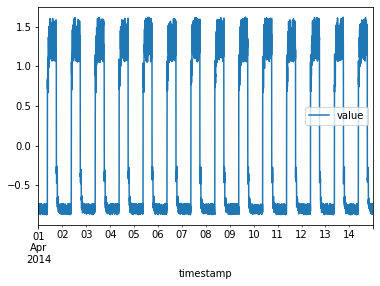

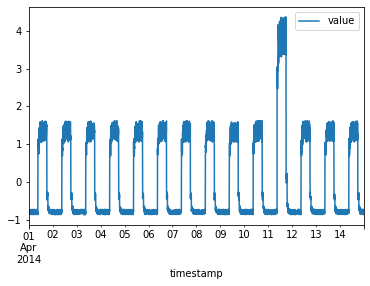

In [6]:
df_train_norm.plot()
df_test_norm.plot()

In [7]:
def create_seq(x,
               window_size=288,
               time_step=1 ):
  y = []
  for i in range(len(x) - window_size + 1):
    if i%time_step==0:
      seq = x[i : (i+window_size)]
      y.append(seq)
  return np.array(y)

train = create_seq(df_train_norm)   
print(f'Train: {train.shape}')

Train: (3745, 288, 1)


In [8]:
test = create_seq(df_test_norm, time_step=288)
print(f'Test: {test.shape}')

Test: (14, 288, 1)


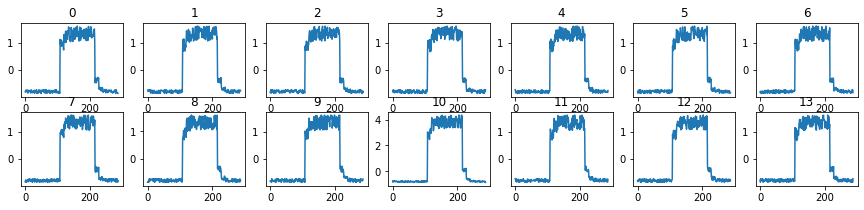

In [9]:
plt.figure(figsize=(15,3))
for i in range(14):
  plt.subplot(2,7,i+1)
  plt.title(i)
  plt.plot(test[i])

### **| 훈련**

In [10]:
model = create_model()
history = model.fit(train, train, epochs=30, batch_size=16)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 288, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 8)             1800      
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 144, 32)          1824      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 144, 32)           0         
                                                           

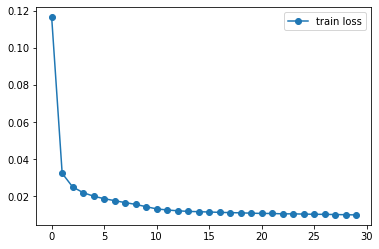

In [11]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [12]:
# 예측
train_pred = model.predict(train)
test_pred = model.predict(test)

train_pred.shape, train.shape, test.shape, test_pred.shape

((3745, 288, 1), (3745, 288, 1), (14, 288, 1), (14, 288, 1))

첫번째 테스트 샘플의 오차: [0.02448175]


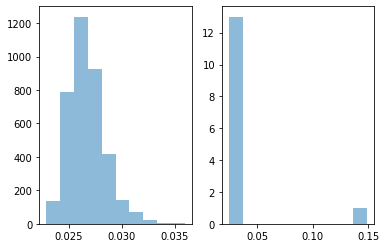

In [13]:
train_mae = np.mean( np.abs(train - train_pred) , axis=1)
test_mae = np.mean( np.abs(test - test_pred) , axis=1)
train_mae.shape, test_mae.shape
print(f'첫번째 테스트 샘플의 오차: {test_mae[0]}')
plt.subplot(121);plt.hist(train_mae, alpha=.5)
plt.subplot(122);plt.hist(test_mae, alpha=.5)
plt.show()

샘플 [10] 손실값: 0.15


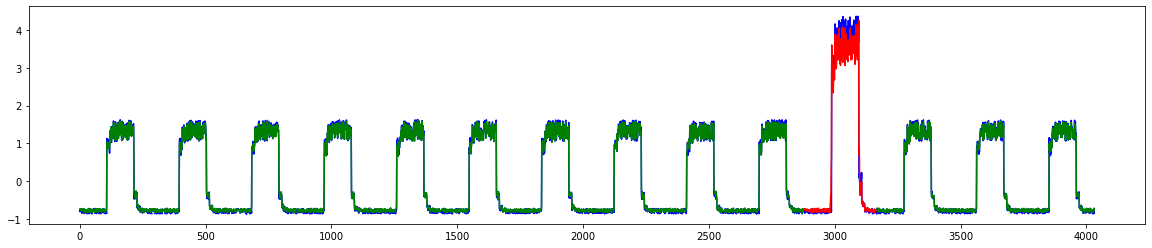

In [14]:
window_size = 288
plt.figure(figsize=(20,4))
for idx in range(len(test)):
  plt.plot(range(window_size*idx, window_size*(idx+1)),test[idx], c='b')
  l = test_mae[idx][0]
  if l>0.1:  
    print(f'샘플 [{idx}] 손실값: {test_mae[idx][0]:.2f}')
    plt.plot(range(window_size*idx, window_size*(idx+1)),test_pred[idx], c='r')
  else: 
    plt.plot(range(window_size*idx, window_size*(idx+1)),test_pred[idx], c='g')

plt.show()

In [15]:
# 모델이 잘 재구현 하지 못한 데이터
np.where(test_mae > 0.06)[0]

array([10])

In [1]:
import sys, os

import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def create_model(input_dims=784):
  # encoder
  x = layers.Input(shape=input_dims, name='x')
  z = layers.Dense(128, activation='relu')(x)
  z = layers.Dense(64, activation='relu')(z)
  z = layers.Dense(16, activation='relu')(z)
  encoder = models.Model(x, z, name='Encoder')

  # decoder
  y = layers.Dense(64, activation='relu')(z)
  y = layers.Dense(128, activation='relu')(y)
  y = layers.Dense(input_dims, activation='sigmoid')(y)
  decoder = models.Model(z, y, name='Decoder')

  # AutoEncoder
  z = encoder(x)
  y = decoder(z)
  model = models.Model(x, y, name='AutoEncoder')
  model.compile(loss= 'mse', 
                optimizer='adam')

  model.summary()

  return encoder, decoder, model

In [3]:
encoder, decoder, model = create_model()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 784)]             0         
                                                                 
 Encoder (Functional)        (None, 16)                109776    
                                                                 
 Decoder (Functional)        (None, 784)               110544    
                                                                 
Total params: 220,320
Trainable params: 220,320
Non-trainable params: 0
_________________________________________________________________


In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# norm
x_train = x_train / 255.0
x_test = x_test / 255.

# flatten
x_train = x_train.reshape( (60000, -1) )
x_test = x_test.reshape( (10000, -1) )

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [7]:
history = model.fit(x_train, x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0235
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0170
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0157
Epoch 4/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0149
Epoch 5/50
469/469 [==============================] - 6s 14ms/step - loss: 0.0143
Epoch 6/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0138
Epoch 7/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0134
Epoch 8/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0132
Epoch 9/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0129
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0128
Epoch 11/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0126
Epoch 12/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0125
Epoch 13/50
469/469 

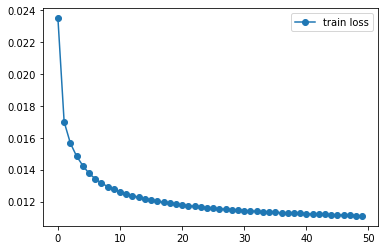

In [8]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

In [9]:
x_recon = model.predict(x_test)
x_test.shape, x_recon.shape

((10000, 784), (10000, 784))

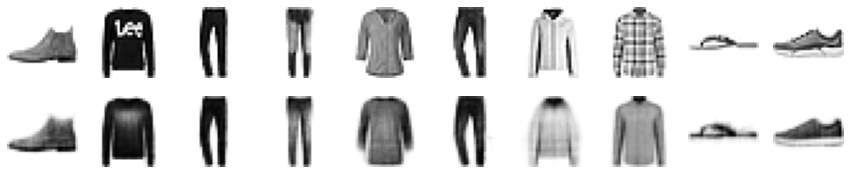

In [10]:
def display_res(org, rec):
  plt.figure(figsize=(15,3))
  for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(org[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
    plt.subplot(2,10,i+11)
    plt.imshow(rec[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
  plt.show()

display_res(x_test, x_recon)

In [11]:
z =encoder(x_test[:1000])
z.shape

TensorShape([1000, 16])

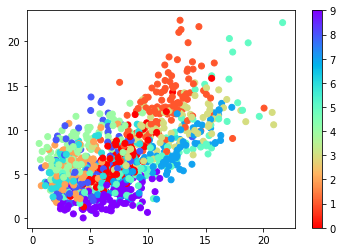

In [12]:
plt.scatter(z[:,1], z[:,2], c=y_test[:1000], cmap='rainbow_r')
plt.colorbar()

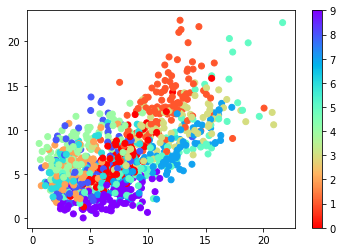

In [13]:
plt.scatter(z[:,1], z[:,2], c=y_test[:1000], cmap='rainbow_r')
plt.colorbar()
plt.show()

(60000, 784) (10000, 784)


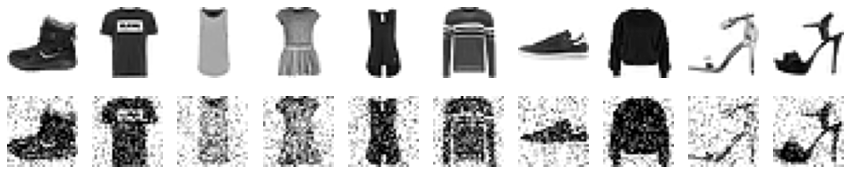

In [14]:
train_noise = np.random.normal(size=x_train.shape)
test_noise = np.random.normal(size=x_test.shape)

factor=0.25
x_train_noisy = x_train + train_noise * factor
x_test_noisy = x_test + test_noise * factor

# 0~1 범위를 벗어나지 않도록
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(train_noise.shape, test_noise.shape)
display_res(x_train, x_train_noisy)

In [15]:
histyr = model.fit(x_train_noisy, x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0141
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0132
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0131
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0130
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0129
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0128
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0128
Epoch 8/50
469/469 [==============================] - 6s 14ms/step - loss: 0.0127
Epoch 9/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0127
Epoch 11/50
469/469 [==============================] - 4s 7ms/step - loss: 0.0126
Epoch 12/50
469/469 [==============================] - 4s 7ms/step - loss: 0.0126
Epoch 13/50
469/469 [=

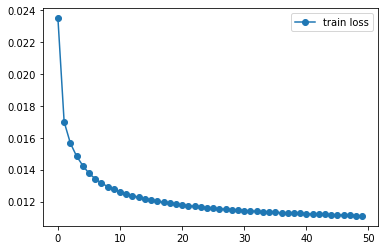

In [16]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

In [17]:
x_recon = model.predict(x_test_noisy)
x_recon.shape, x_test_noisy

((10000, 784),
 array([[0.14948024, 0.        , 0.        , ..., 0.00144733, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.0948047 , 0.        ,
         0.        ],
        [0.02201817, 0.52459625, 0.09545294, ..., 0.11512156, 0.        ,
         0.        ],
        ...,
        [0.01455867, 0.11126058, 0.02803374, ..., 0.4497183 , 0.19765918,
         0.        ],
        [0.        , 0.        , 0.18422609, ..., 0.35511162, 0.        ,
         0.        ],
        [0.17919633, 0.04848746, 0.        , ..., 0.        , 0.10691886,
         0.20098555]]))

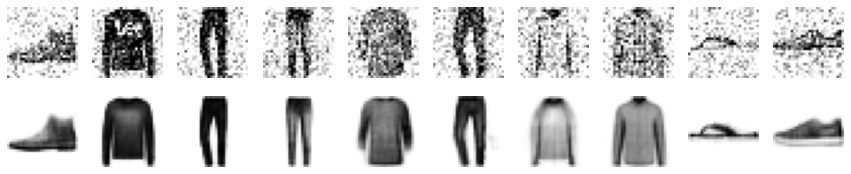

In [18]:
display_res(x_test_noisy, x_recon)